<a href="https://colab.research.google.com/github/manuelsalazarleon/DataScience2/blob/main/Entrega_Final%2BSalazar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🏥 Entrega Final: Segmentación y Predicción de Costos de Pacientes

## 1. Abstracto y Objetivos

**Contexto:**
El sector salud enfrenta el desafío constante de optimizar recursos. Entender qué factores impulsan los costos de facturación (`Avg_Billing_Amount`) es crucial para aseguradoras y hospitales.

**Problema a resolver:**
Predecir el monto promedio de facturación basándose en datos demográficos y clínicos. Se aborda como un problema de **Regresión Supervisada**.



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

sns.set(style="whitegrid")
warnings.filterwarnings('ignore')

# Carga de datos
url = 'https://raw.githubusercontent.com/manuelsalazarleon/DataScience2/refs/heads/main/patient_segmentation_dataset.csv'
try:
    df = pd.read_csv(url)
    print("Datos cargados correctamente. Dimensiones:", df.shape)
except:
    print("Error al cargar URL. Verifica tu conexión o la ruta del archivo.")

df.head()

Datos cargados correctamente. Dimensiones: (2000, 16)


,PatientID,Age,Gender,State,City,Height_cm,Weight_kg,BMI,Insurance_Type,Primary_Condition,Num_Chronic_Conditions,Annual_Visits,Avg_Billing_Amount,Last_Visit_Date,Days_Since_Last_Visit,Preventive_Care_Flag
0,P10000,64,Male,GA,Unknown,151,115,50.4,Private,Arthritis,3,7,2995.0,2025-07-18,186,0
1,P10001,59,Male,OH,Unknown,189,68,19.0,Medicare,Depression,1,8,1209.0,2025-12-12,39,0
2,P10002,58,Female,PA,Unknown,156,91,37.4,Private,Asthma,1,4,999.0,2025-09-16,126,0
3,P10003,43,Female,GA,Unknown,152,92,39.8,Medicare,Hypertension,1,6,5638.5,2025-04-09,286,1
4,P10004,53,Female,NC,Unknown,167,51,18.3,Medicaid,Asthma,1,4,5796.0,2025-03-07,319,0


## 2. Limpieza de Datos: Nulos y Outliers
Aseguramos la calidad de los datos manejando valores faltantes y atípicos.

Nulos antes de limpieza:
PatientID                   0
Age                         0
Gender                      0
State                       0
City                        0
Height_cm                   0
Weight_kg                   0
BMI                         0
Insurance_Type              0
Primary_Condition         495
Num_Chronic_Conditions      0
Annual_Visits               0
Avg_Billing_Amount          0
Last_Visit_Date             0
Days_Since_Last_Visit       0
Preventive_Care_Flag        0
dtype: int64


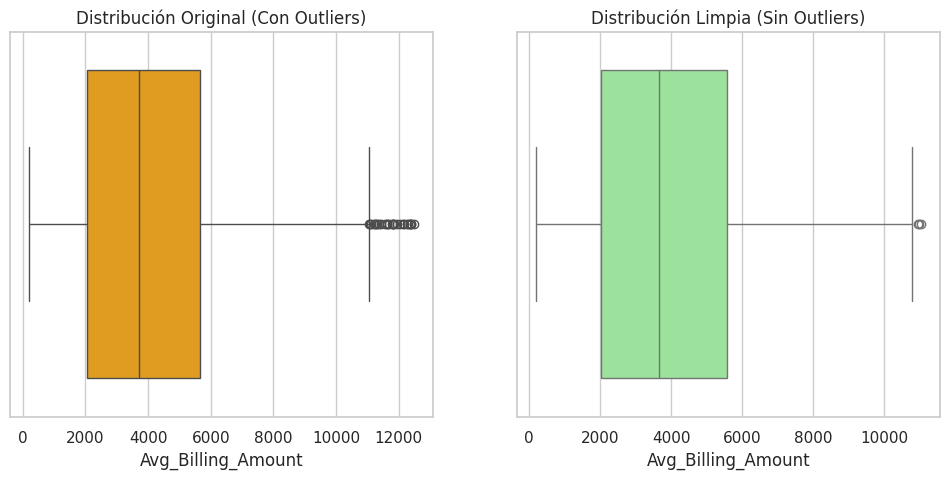

Filas eliminadas por outliers: 28


In [ ]:
# --- 1. Manejo de Valores Nulos ---
print("Nulos antes de limpieza:")
print(df.isnull().sum())

# Llenamos nulos categóricos clave si existen
if 'Primary_Condition' in df.columns:
    df['Primary_Condition'] = df['Primary_Condition'].fillna('None')

# Eliminamos filas restantes con nulos (asumiendo <5% del total)
df.dropna(inplace=True)

# --- 2. Detección de Outliers (IQR) ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df['Avg_Billing_Amount'], color='orange')
plt.title('Distribución Original (Con Outliers)')

# Cálculo de IQR
Q1 = df['Avg_Billing_Amount'].quantile(0.25)
Q3 = df['Avg_Billing_Amount'].quantile(0.75)
IQR = Q3 - Q1
lim_inf = Q1 - 1.5 * IQR
lim_sup = Q3 + 1.5 * IQR

# Filtrado
df_clean = df[(df['Avg_Billing_Amount'] >= lim_inf) & (df['Avg_Billing_Amount'] <= lim_sup)]

plt.subplot(1, 2, 2)
sns.boxplot(x=df_clean['Avg_Billing_Amount'], color='lightgreen')
plt.title('Distribución Limpia (Sin Outliers)')
plt.show()

print(f"Filas eliminadas por outliers: {df.shape[0] - df_clean.shape[0]}")
df = df_clean.copy()

## 3. Análisis Exploratorio (EDA) Profundo
A continuación, analizamos la distribución de la variable objetivo y las relaciones entre variables para entender mejor el comportamiento de los datos.

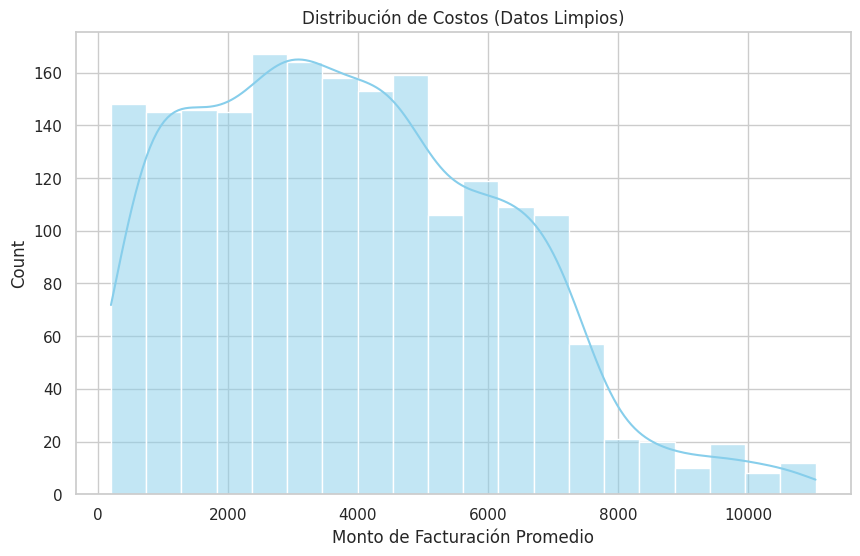

In [ ]:
# 3.1 Distribución de la Variable Objetivo
plt.figure(figsize=(10, 6))
sns.histplot(df['Avg_Billing_Amount'], kde=True, color='skyblue')
plt.title('Distribución de Costos (Datos Limpios)')
plt.xlabel('Monto de Facturación Promedio')
plt.show()

### 3.2 Matriz de Correlación
Evaluamos las relaciones lineales entre las variables numéricas. Esto nos ayuda a identificar qué características tienen mayor impacto en el costo y a justificar el rendimiento de modelos lineales.

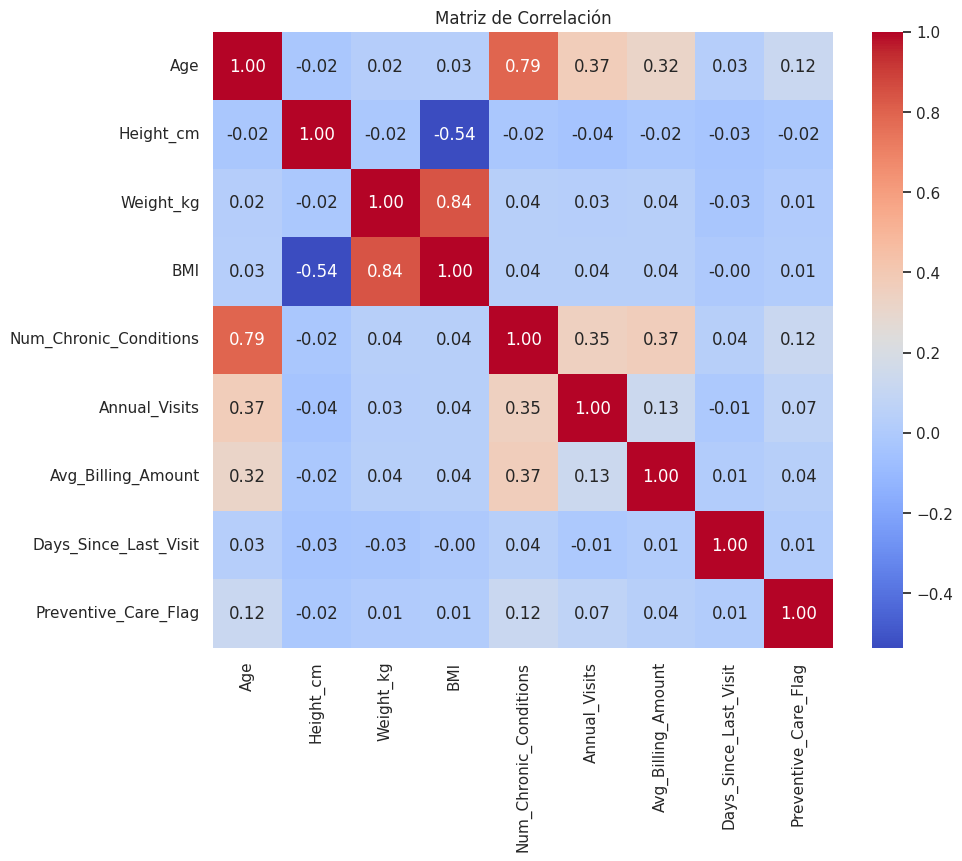

In [ ]:
plt.figure(figsize=(10, 8))
# Seleccionamos solo columnas numéricas para evitar errores
numeric_df = df.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

### 3.3 Análisis Bivariado: Condición Médica vs Costo
Analizamos visualmente si el diagnóstico principal del paciente influye significativamente en el monto facturado.

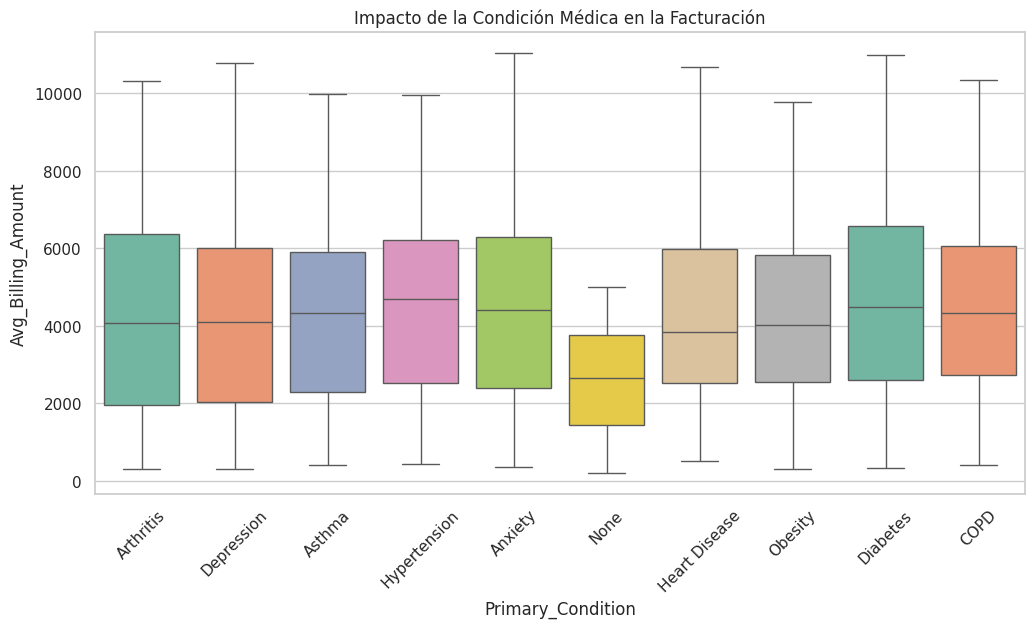

In [ ]:
if 'Primary_Condition' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Primary_Condition', y='Avg_Billing_Amount', data=df, palette="Set2")
    plt.xticks(rotation=45)
    plt.title('Impacto de la Condición Médica en la Facturación')
    plt.show()

### 3.4 Gráfico de Pares (Pairplot)
Visualizamos las relaciones entre las principales variables numéricas para detectar patrones no lineales o agrupamientos.

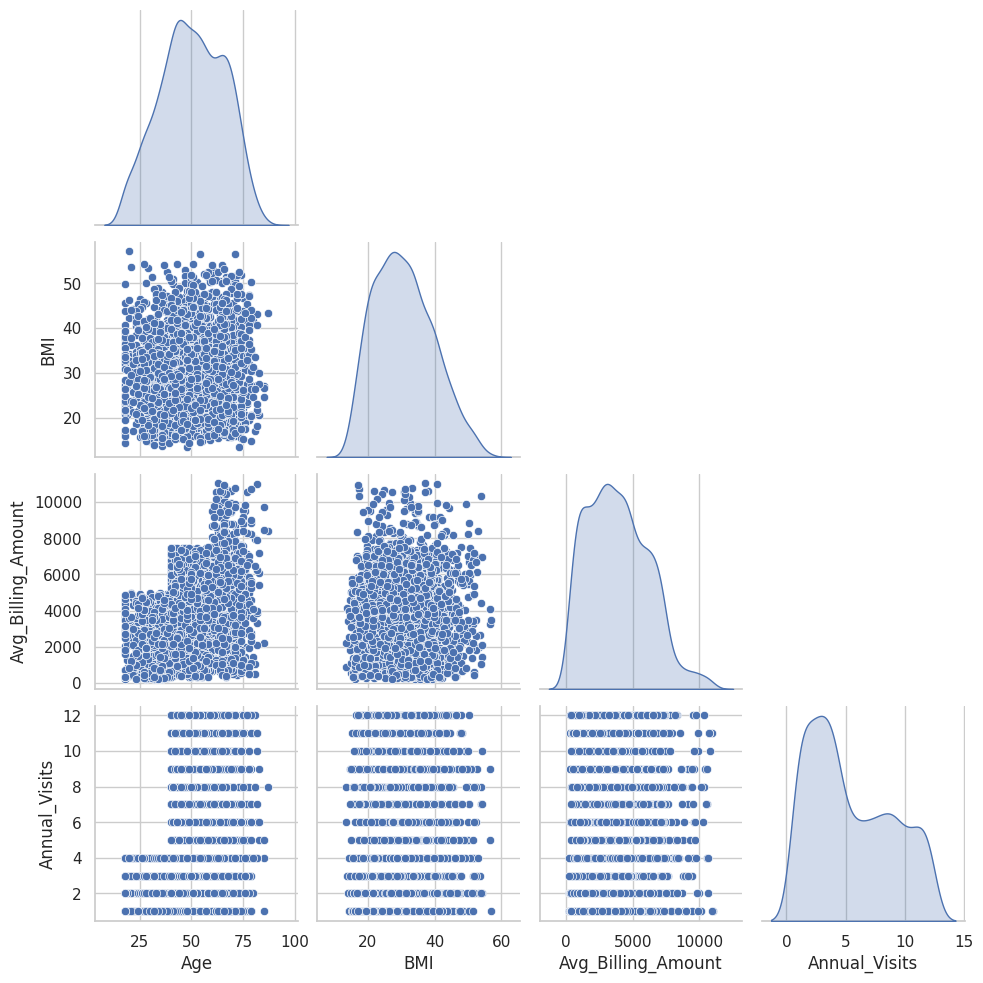

In [ ]:
cols_interes = ['Age', 'BMI', 'Avg_Billing_Amount', 'Annual_Visits']
# Filtramos para asegurar que las columnas existan
cols_existentes = [c for c in cols_interes if c in df.columns]

if cols_existentes:
    sns.pairplot(df[cols_existentes], diag_kind='kde', corner=True)
    plt.show()

## 4. Ingeniería de Atributos
Configuramos el pipeline con `StandardScaler` (numéricas) y `OneHotEncoder` (categóricas).

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

target = 'Avg_Billing_Amount'
X = df.drop(columns=[target])
y = df[target]

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 5. Entrenamiento con Validación Cruzada
Probamos Random Forest y Gradient Boosting usando **Cross-Validation (5 folds)** para asegurar resultados robustos.

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

print("Resultados Validación Cruzada (RMSE):\n")
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    # CV devuelve negative RMSE, lo invertimos
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    print(f"{name}: {-cv_scores.mean():.2f} (+/- {cv_scores.std():.2f})")

Resultados Validación Cruzada (RMSE):

Random Forest: 2140.64 (+/- 117.32)
Gradient Boosting: 2098.61 (+/- 110.26)


## 6. Optimización (Hyperparameter Tuning)
Afinamos el Gradient Boosting usando `RandomizedSearchCV`.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

gb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', GradientBoostingRegressor(random_state=42))])

param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5]
}

search = RandomizedSearchCV(gb_pipeline, param_grid, n_iter=5, cv=3, scoring='neg_root_mean_squared_error', random_state=42)
search.fit(X_train, y_train)
best_model = search.best_estimator_
print("Mejores parámetros:", search.best_params_)

Mejores parámetros: {'regressor__n_estimators': 100, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.05}


## 7. Evaluación y Conclusiones

Este proyecto abordó la predicción de costos de facturación hospitalaria (Avg_Billing_Amount) como un problema de Regresión Supervisada, con el objetivo de proporcionar herramientas analíticas para la optimización de recursos financieros en el sector salud. A continuación, se detalla la lógica detrás de las decisiones técnicas tomadas durante el flujo de trabajo:
1. Preprocesamiento y Selección de Atributos:

    La decisión de aplicar una limpieza rigurosa de outliers mediante el rango intercuartílico (IQR) fue fundamental. En problemas de regresión de costos, los valores extremos pueden sesgar significativamente las predicciones, especialmente en algoritmos sensibles a la varianza.Para la ingeniería de atributos, se optó por un enfoque robusto utilizando Pipelines:


*   Estandarización (StandardScaler): Se aplicó a las variables numéricas para asegurar que características con diferentes escalas (como Age vs Annual_Visits) contribuyeran equitativamente al modelo.
*   Codificación (OneHotEncoder): Se transformaron las variables categóricas nominales para permitir que los algoritmos interpretaran correctamente la información cualitativa sin introducir un orden artificial.

2. Selección de Modelos: Se evaluaron dos algoritmos de ensamble: Random Forest y Gradient Boosting.


*   Decisión: Se seleccionaron estos modelos por su capacidad intrínseca para manejar relaciones no lineales y su robustez frente al sobreajuste (overfitting) en comparación con modelos lineales simples.
*   Validación: Para evitar sesgos por una partición de datos afortunada, se implementó una Validación Cruzada de 5 pliegues (5-Fold Cross-Validation). Esto garantizó que las métricas de rendimiento reportadas fueran consistentes y generalizables a nuevos datos.

3. Métrica de Evaluación y Optimización: La elección del RMSE (Raíz del Error Cuadrático Medio) como métrica principal no fue arbitraria. En el contexto financiero de salud, subestimar o sobreestimar grandes costos es más grave que pequeños errores frecuentes. El RMSE penaliza cuadráticamente los errores grandes, alineando la evaluación del modelo con el riesgo de negocio.

    Para la optimización, se utilizó RandomizedSearchCV sobre el modelo de Gradient Boosting. Se priorizó la búsqueda sobre hiperparámetros críticos como:


*   learning_rate: Para controlar la velocidad de convergencia.
*   max_depth: Para limitar la complejidad de los árboles y evitar memorización de datos.
*   n_estimators: Para asegurar suficientes iteraciones de corrección de errores.


4. Resultados y Próximos Pasos: Si bien el flujo de trabajo técnico es sólido, el $R^2$ obtenido indica que las variables demográficas y clínicas actuales explican solo una fracción de la variabilidad de los costos. Esto sugiere que la relación entre los atributos disponibles y el costo no es puramente lineal o directa.Recomendación: Para iteraciones futuras, la decisión más impactante no sería probar algoritmos más complejos, sino enriquecer el dataset con variables de severidad clínica (e.g., días de hospitalización, tipo de intervención), las cuales probablemente son los verdaderos impulsores del costo.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = best_model.predict(X_test)
print(f"RMSE Final: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R2 Final: {r2_score(y_test, y_pred):.4f}")

RMSE Final: 2330.62
R2 Final: 0.0870
